In [1]:
!pip install textblob

In [2]:
!pip install wordcloud

In [3]:
!pip install cufflinks

In [4]:
!pip install nltk

In [5]:
!pip install --upgrade nltk

# Step 1: Importing all the necessary libraries

In [6]:
import numpy as np
import pandas as pd
import string
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
warnings.warn("This will not show")

pd.set_option("display.max_columns", None)

# Step 2: Let's Import dataset

In [7]:
df = pd.read_csv("C:\\Users\\satya\\Downloads\\amazon_review.csv")

# Let's read our data.  There are total 4915 rows × 12 columns

In [8]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",I bought this Sandisk 16GB Class 10 to use wit...,1.0,Do not waste your money.,1374537600,2013-07-23,503,0,0
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",Used this for extending the capabilities of my...,5.0,Great item!,1377129600,2013-08-22,473,0,0
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5.0,Fast and reliable memory card,1396224000,2014-03-31,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.0,Great little card,1379289600,2013-09-16,448,0,0


# Step 3: Any Missing values? Let's do EDA

## Let's create a function to check missing values

In [9]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("No missing values found")
    else:
        print("Found Missing Values")
        missing_values = missing_values[missing_values > 0]
        missing_values = missing_values.sort_values()
    return missing_values

check_missing_values(df)

Found Missing Values


reviewerName    1
reviewText      1
dtype: int64

## As there is 1 missing value in each of these 2 categorical variables "reviewerName & reviewText", I decided to drop them as it causes no impact on the data because it is only 1 row

## Lets create a function to drop that 1 missing value in each of these 2 columns

In [10]:
def drop_missing_values(df,axis,how,subset,inplace):
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        if inplace:
            df.dropna(axis=axis, how=how, subset=subset, inplace=inplace)
        else:
            return df.dropna(axis=axis, how=how, subset=subset)
    else:
        return df
drop_missing_values(df=df,axis=0,how='any',subset=['reviewerName','reviewText'],inplace=True)

## checking null or missing values with info() method without creating function

### Let's check the missing values by calling the 'check_missing_values' function again

In [11]:
check_missing_values(df)

No missing values found


reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

### Now as our data set has no missing values & clean,I would like to visualise the 'overall' column in our data which represents ratings from 1 to 5

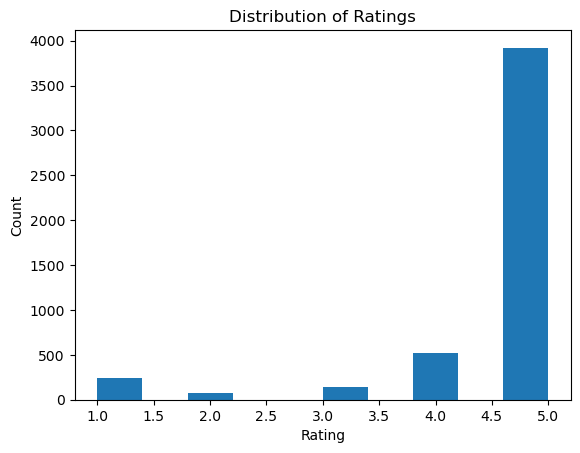

In [12]:
# Plotting the 'overall' column as a bar plot
overall_ratings = df['overall'].sort_index()
# print(overall_ratings)

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

plt.hist(overall_ratings)
plt.show() 

### Now I would like to explore column 'reviewText' and Visualise it

In [13]:
# Let's get the length of the teviewText
reviewText_length = df['reviewText'].apply(len)
print(reviewText_length)

1       158
2       166
3       340
4       290
5       282
       ... 
4910    320
4911    148
4912    233
4913     91
4914    199
Name: reviewText, Length: 4913, dtype: int64


### lets see the statistical analysis of the review text length column. for instance, Mean Median,Mode,SD,Min,Max

In [14]:
reviewText_length.describe()

count    4913.000000
mean      267.799919
std       328.877502
min         3.000000
25%       123.000000
50%       172.000000
75%       289.000000
max      8638.000000
Name: reviewText, dtype: float64

### Let's create a function to return the  shortest reviewtext

In [15]:
# Let's see the shortest reviewText 
def shortest_reviewText(column):
    shortest_review = min(df['reviewText'], key=len)
    return shortest_review
shortest_reviewText(column = 'reviewText')

'YES'

### Let's create a function to return the longest reviewtext

In [16]:
def shortest_reviewText(column):
    shortest_review = max(df['reviewText'], key=len)
    return shortest_review
shortest_reviewText(column = 'reviewText')

'NOTE:  please read the last update (scroll to the bottom) - I\'m leaving this review as 1 star as it appears to help others who purchased and had a similar experience.I give SanDisk 5 stars for customer service and 1 star for the product (for those manufactured in the past)  For those newly manufactured products that contain the software ROM fix, I\'d give the product 5 stars.To all those who purchased this card due to all the great reviews.... and then used it in a Galaxy S4 (GS4) smartphone for storage, the solution to the problem is not one you can solve without returning the card to SanDisk for a replacement under warranty.  Believe me I tried everything that the Google searches returned as solutions... formatting as exFAT, formatting in the GS4 then copying data to the card while in the phone etc.... nothing worked... and so now please stop pulling out your hair and hopefully you will get the same result which I hope to get soon (just RMA\'d and will send it back tomorrow for a f

### Let's clean the the column 'reviewText' for better analysis (Text-PreProcessing)

### Let's create a function called TextProcessing to clean our dependent variable(reviewText)

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
def text_preprocessing(df, dep_var):
    ##casefolding. (converting the text in our column from upper to lower case)
    df[dep_var] = df[dep_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

    ##Removing Punctuation
    # df[dep_var] = df[dep_var].str.replace('[^\w\s]','')
    df[dep_var] = df[dep_var].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
                               
    ##Removing Numbers from the text
    df[dep_var] = df[dep_var].str.replace('\d','')

    ##Stopwords
    sw =  stopwords.words('english')
    df[dep_var] = df[dep_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

    ##Remove RareWords
    ##Calculates the frequency of each word in the column
    temp_df = pd.Series(' '.join(df[dep_var]).split()).value_counts()
    drops = temp_df[temp_df <=1]
    df[dep_var] = df[dep_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

    ##Lemmatize
    lemmatizer = WordNetLemmatizer()  # Initialize WordNetLemmatizer
    df[dep_var] = df[dep_var].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

    return df

df = text_preprocessing(df=df, dep_var= "reviewText")

In [22]:
df["reviewText"].head()

1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked 64gb card went south 3 one held p...
4    bought retail packaging arrived legit envelope...
5    mini storage doesnt anything else supposed pur...
Name: reviewText, dtype: object

## Let's visualise our 'reviewtext' column by word cloud

### Let's create a 'textvisualisation' function to visualise our column

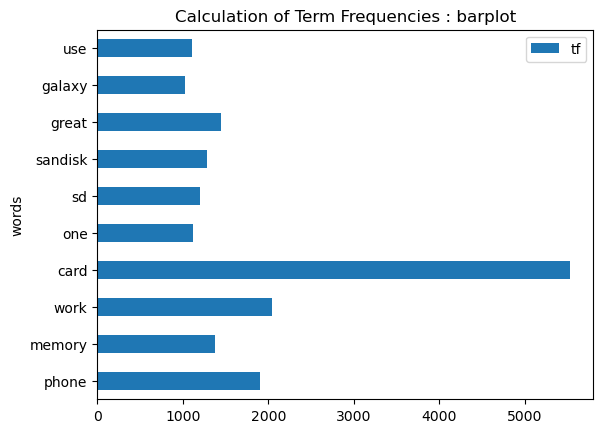

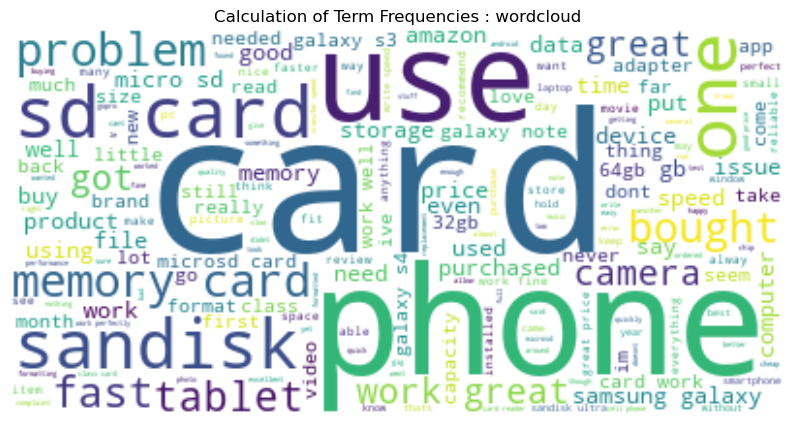

In [23]:
def text_visualisation(df, dep_var, barplot=True, wordcloud=True):
    #calculate the terms frequencies in the column reviewText
    tf = df[dep_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns=["words", "tf"]

    #barplot
    if barplot:
        tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
        plt.title("Calculation of Term Frequencies : barplot")
        plt.show()

    #wordCloud
    if wordcloud:
        text = " ".join(i for i in df[dep_var])
        wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
        plt.figure(figsize=[10, 10])
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Calculation of Term Frequencies : wordcloud")
        plt.show()
        wordcloud.to_file("wordcloud.png")

text_visualisation(df, "reviewText")

### Let's see the positive reviewTexts and Negitive reviewText by word cloud

### I decided to categorise positive texts which are having rating 5 

In [24]:
positive = df['overall']==5 

### I decided to categorise negative texts which are having rating less than 5

In [25]:
negative = df['overall']<5

### lets see the positive texts count

In [26]:
positive_count = positive.sum()

In [27]:
print(positive_count)

3921


### lets see the negative texts count

In [28]:
negative_count = negative.sum()

In [29]:
print(negative_count)

992


### we can see 3921 positive reviews(rating 5) & 992 negative reviews(rating 4 and below) TOTAL 4913 rows

# Sentiment Analysis

### Let's create a column called sentiment_score to provide a quantitative measure of the sentiment expressed in textdata. 

### Let's create a function called 'sentiment_score'

In [30]:
def create_sentiement_score(df, dep_var):
    senti = SentimentIntensityAnalyzer()
    df["sentiment_score"] = df[dep_var].apply(lambda x: senti.polarity_scores(x)["compound"])
                                              
create_sentiement_score(df, "reviewText")

In [31]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,sentiment_score
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.0000
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,0.4019
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked 64gb card went south 3 one held p...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.6486
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.0,best deal around,1373673600,2013-07-13,513,0,0,0.8591
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",mini storage doesnt anything else supposed pur...,5.0,Not a lot to really be said,1367193600,2013-04-29,588,0,0,0.0000


# Feature Engineering

In [32]:
#Create Lables
def create_label(df, dep_var, indep_var):
    senti = SentimentIntensityAnalyzer()
    df[indep_var] = df[dep_var].apply(lambda x: "pos" if senti.polarity_scores(x)["compound"] > 0 else "neg")
    df[indep_var] = LabelEncoder().fit_transform(df[indep_var])

    X = df[dep_var]
    y = df[indep_var]

    return X,y 

In [33]:
#Let's call our function into variables called X , y
X, y = create_label(df, "reviewText", "sentiment_label")

In [34]:
X

1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked 64gb card went south 3 one held p...
4       bought retail packaging arrived legit envelope...
5       mini storage doesnt anything else supposed pur...
                              ...                        
4910    bought sandisk 16gb class 10 use htc inspire 3...
4911    used capability samsung galaxy note 10 greatly...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing 64gb micro sd card crappin...
Name: reviewText, Length: 4913, dtype: object

In [35]:
y

1       0
2       1
3       1
4       1
5       0
       ..
4910    1
4911    1
4912    1
4913    1
4914    1
Name: sentiment_label, Length: 4913, dtype: int32

# Let's Split the dataset into training and testing sets

In [36]:
#Split the dataset
def split_data(df, X, y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, random_state =1)
    return train_x, test_x, train_y, test_y

#let's call our function into variables
train_x, test_x, train_y, test_y = split_data(df, X, y)

In [37]:
train_x

1993    card good havent problem yet good price fit pr...
233     initially inserted card samsung galaxy s3 reco...
3437    installed contour camera work taking 1080p hd ...
3115    inserted galaxy note powered phone went storag...
4225    send back sandisk replace cost nice still lost...
                              ...                        
2897    nowadays memory dont fastest write speed even ...
2765    bought android phone kept stating medium scann...
907     ive never problem sandisk memory product use 3...
3982    problem report work described scandisk make st...
237     purchased card new nokia lumia 520 smart phone...
Name: reviewText, Length: 3684, dtype: object

In [38]:
test_x

351     popped sony xperia tablet z work sense ever ru...
773     used sony as15 using almost month yet encounte...
2176    device work exactly expected hold lot music vi...
3889    bought new galaxy tab work flawlessly nothing ...
1227    excellent card currently installed samsung gs3...
                              ...                        
3729    im using 32 gb micro sandisk ultra record 1080...
3191    work well use galaxy s4 expansion card work we...
2697    ok transferred file old microsd card one1 turn...
2122    device work advertised tremendous price found ...
942     good price good quality put phone extra storag...
Name: reviewText, Length: 1229, dtype: object

# Feature Extraction

## Let's convert text data into count vectors and count Vectors in train_x  & test_x

In [39]:
def create_features_count(train_x, test_x):
    #initialize the instance of the class CountVectorizer()
    vectorizer = CountVectorizer()
    x_train_count_vectorizer = vectorizer.fit_transform(train_x)
    x_test_count_vectorizer = vectorizer.fit_transform(test_x)

    return x_train_count_vectorizer, x_test_count_vectorizer

#Let's call our function
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)   

# Let's convert text data into TF-IDF Word Vectors (Term Frequency-Inverse Document Frequency)

In [40]:
#create a function to tfidf word
def create_features_TFIDF_word(train_x, test_x):
    #Initialise the instance of the class TfidfVectorize()
    tfidf_word_vectorizer = TfidfVectorizer()
    x_train_tfidf_word = tfidf_word_vectorizer.fit_transform(train_x)
    x_test_tfidf_word = tfidf_word_vectorizer.fit_transform(test_x)


    return x_train_tfidf_word, x_test_tfidf_word

#Let's call our function
x_train_tfidf_word, x_test_tfidf_word = create_features_TFIDF_word(train_x, test_x) 

# Let's convert text data into TF-IDF Ngram Vectors

In [41]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram

#Let's call our function
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

# Let's convert text data into TF-IDF Character  Vectors ( extracts features at the character level instead of the word level)

In [42]:
def create_features_TFIDF_chars(train_x, test_x):
  # TF-IDF Characters
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(train_x)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars

#Let's call our function
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

# Sentiment Modeling - Creatin Models

## I decided to go with 2 models. 1. Logistic Regression 2. Random Forest to perform sentiment analysis.

### lets do Logistic Regression

In [43]:
# Logistic Regression
def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  Loj_count = LogisticRegression(solver='lbfgs', max_iter=1000)
  Loj_model_count = Loj_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(Loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  Loj_word = LogisticRegression(solver='lbfgs', max_iter=1000)
  Loj_model_word = Loj_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(Loj_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  Loj_ngram = LogisticRegression(solver='lbfgs', max_iter=1000)
  Loj_model_ngram = Loj_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(Loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  Loj_chars = LogisticRegression(solver='lbfgs', max_iter=1000)
  Loj_model_chars = Loj_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(Loj_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return Loj_model_count, Loj_model_word, Loj_model_ngram, Loj_model_chars

#Let's call our function
loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars = crate_model_logistic(train_x, test_x)

Accuracy - Count Vectors: 0.832
Accuracy - TF-IDF Word: 0.798
Accuracy TF-IDF ngram: 0.796
Accuracy TF-IDF Characters: 0.797


### lets do Random Forest

In [44]:
def crate_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier()
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier()
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier()
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  rf_chars = RandomForestClassifier()
  rf_model_chars = rf_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(rf_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars

#Let's call our function
rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars = crate_model_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.804
Accuracy - TF-IDF Word: 0.797
Accuracy TF-IDF ngram: 0.795
Accuracy TF-IDF Characters: 0.800


# Prediction

In [50]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Positive")
  else:
    print("Comment is Negative")

In [62]:
# Logistic Regression
predict_count(train_x, model=loj_model_count, new_comment="  I highly recommend the this TWS Earbuds to anyone in the market  ")

Comment is Positive


In [64]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="Not sturdy at all-- Not worth the money. Only buy if your laptop is ultra-light.")

Comment is Negative


# THANK YOU